

# Animated polar plot with oceanographic data

**Original Notebook**:
https://matplotlib.org/matplotblog/posts/animated-polar-plot/


In [1]:
import numpy as np
import pandas as pd

from argopy import DataFetcher as ArgoDataFetcher

argo_loader = ArgoDataFetcher(cache=True)

In [2]:
# Query surface and 1000m temp in Med sea with argopy

df1 = argo_loader.region(
    [-1.2, 29.0, 28.0, 46.0, 0, 10.0, "2009-12", "2020-01"]
).to_xarray()
df2 = argo_loader.region(
    [-1.2, 29.0, 28.0, 46.0, 975.0, 1025.0, "2009-12", "2020-01"]
).to_xarray()

In [3]:
start_date = "2010-01-04"
end_date = "2020-01-07"

In [4]:
# Parameters
start_date = "2016-01-01"
end_date = "2020-01-03"


In [5]:
# Weekly date array

daterange = np.arange(start_date, end_date, dtype="datetime64[7D]")
dayoftheyear = pd.DatetimeIndex(
    np.array(daterange, dtype="datetime64[D]") + 3
).dayofyear  # middle of the week

activeyear = pd.DatetimeIndex(
    np.array(daterange, dtype="datetime64[D]") + 3
).year  # extract year

In [6]:
# Init final arrays

tsurf = np.zeros(len(daterange))
t1000 = np.zeros(len(daterange))

In [7]:
# Filling arrays

for i in range(len(daterange)):
    i1 = (df1["TIME"] >= daterange[i]) & (df1["TIME"] < daterange[i] + 7)
    i2 = (df2["TIME"] >= daterange[i]) & (df2["TIME"] < daterange[i] + 7)
    tsurf[i] = df1.where(i1, drop=True)["TEMP"].mean().values
    t1000[i] = df2.where(i2, drop=True)["TEMP"].mean().values

In [8]:
# Creating dataframe

d = {
    "date": np.array(daterange, dtype="datetime64[D]"),
    "tsurf": tsurf,
    "t1000": t1000,
}
ndf = pd.DataFrame(data=d)
ndf.head()

,date,tsurf,t1000
0,2015-12-31,16.008982,13.473844
1,2016-01-07,15.808208,13.474958
2,2016-01-14,15.696154,13.482945
3,2016-01-21,15.573696,13.489998
4,2016-01-28,15.446599,13.481531


In [9]:
from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

plt.rcParams["xtick.major.pad"] = "17"
plt.rcParams["axes.axisbelow"] = False
matplotlib.rc("axes", edgecolor="w")

big_angle = 360 / 12  # How we split our polar space

date_angle = (
    ((360 / 365) * dayoftheyear) * np.pi / 180
)  # For a day, a corresponding angle

# inner and outer ring limit values

inner = 10
outer = 30
# setting our color values

ocean_color = ["#ff7f50", "#004752"]

In [10]:
def dress_axes(ax):
    ax.set_facecolor("w")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    # Here is how we position the months labels

    middles = np.arange(big_angle / 2, 360, big_angle) * np.pi / 180
    ax.set_xticks(middles)
    ax.set_xticklabels(
        [
            "January",
            "February",
            "March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December",
        ]
    )
    ax.set_yticks([15, 20, 25])
    ax.set_yticklabels(["15°C", "20°C", "25°C"])
    # Changing radial ticks angle

    ax.set_rlabel_position(359)
    ax.tick_params(axis="both", color="w")
    plt.grid(None, axis="x")
    plt.grid(axis="y", color="w", linestyle=":", linewidth=1)
    # Here is the bar plot that we use as background

    bars = ax.bar(
        middles,
        outer,
        width=big_angle * np.pi / 180,
        bottom=inner,
        color="lightgray",
        edgecolor="w",
        zorder=0,
    )
    plt.ylim([2, outer])
    # Custom legend

    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Surface",
            markerfacecolor=ocean_color[0],
            markersize=15,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="1000m",
            markerfacecolor=ocean_color[1],
            markersize=15,
        ),
    ]
    ax.legend(handles=legend_elements, loc="center", fontsize=13, frameon=False)
    # Main title for the figure

    plt.suptitle(
        "Mediterranean temperature from Argo profiles",
        fontsize=16,
        horizontalalignment="center",
    )

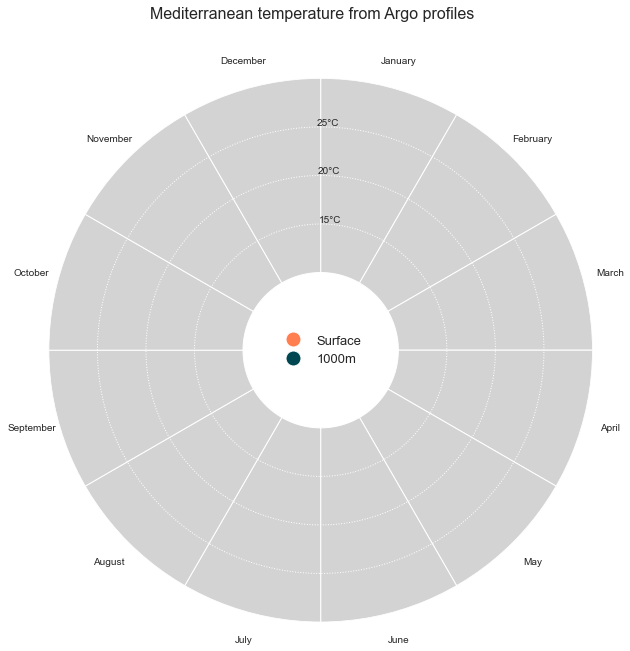

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
dress_axes(ax)
plt.show()

In [12]:
def draw_data(i):
    # Clear

    ax.cla()
    # Redressing axes

    dress_axes(ax)
    # Limit between thin lines and thick line, this is current date minus 51 weeks basically.

    # why 51 and not 52 ? That create a small gap before the current date, which is prettier

    i0 = np.max([i - 51, 0])

    ax.plot(
        date_angle[i0 : i + 1],
        ndf["tsurf"][i0 : i + 1],
        "-",
        color=ocean_color[0],
        alpha=1.0,
        linewidth=5,
    )
    ax.plot(
        date_angle[0 : i + 1],
        ndf["tsurf"][0 : i + 1],
        "-",
        color=ocean_color[0],
        linewidth=0.7,
    )

    ax.plot(
        date_angle[i0 : i + 1],
        ndf["t1000"][i0 : i + 1],
        "-",
        color=ocean_color[1],
        alpha=1.0,
        linewidth=5,
    )
    ax.plot(
        date_angle[0 : i + 1],
        ndf["t1000"][0 : i + 1],
        "-",
        color=ocean_color[1],
        linewidth=0.7,
    )

    # Plotting a line to spot the current date easily

    ax.plot([date_angle[i], date_angle[i]], [inner, outer], "k-", linewidth=0.5)
    # Display the current year as a title, just beneath the suptitle

    plt.title(str(activeyear[i]), fontsize=16, horizontalalignment="center")

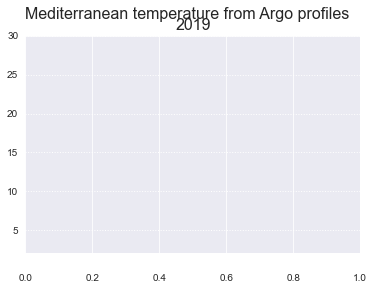

In [13]:
anim = FuncAnimation(
    fig, draw_data, interval=40, frames=len(daterange) - 1, repeat=False
)

HTML(anim.to_html5_video())